In [8]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [9]:
# 資料轉換函數
data_transforms = {
    # 訓練資料集採用資料增強與標準化轉換
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # 隨機剪裁並縮放
        transforms.RandomHorizontalFlip(), # 隨機水平翻轉
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 標準化
    ]),
    # 驗證資料集僅採用資料標準化轉換
    'val': transforms.Compose([
        transforms.Resize(256),  # 縮放
        transforms.CenterCrop(224), # 中央剪裁
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 標準化
    ]),
}

In [11]:
# 資料路徑
data_dir = 'drive/MyDrive/hymenoptera_data/hymenoptera_data'

# 建立 Dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

# 建立 DataLoader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
               shuffle=True, num_workers=4)
               for x in ['train', 'val']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
# 取得訓練資料集與驗證資料集的資料量
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 244, 'val': 153}


In [13]:
# 取得各類別的名稱
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


In [14]:
# 若 CUDA 環境可用，則使用 GPU 計算，否則使用 CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [15]:
# 將 Tensor 資料轉為原來的圖片
def tensor2img(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Text(0.5, 1.0, "['bees', 'bees', 'bees', 'ants']")

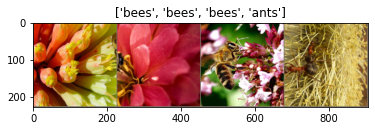

In [16]:
# 取得一個 batch 的訓練資料
inputs, classes = next(iter(dataloaders['train']))

# 將多張圖片拼成一張 grid 圖
out = torchvision.utils.make_grid(inputs)

# 顯示圖片
img = tensor2img(out)
plt.imshow(img)
plt.title([class_names[x] for x in classes])

In [17]:
# 訓練模型用函數
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() # 記錄開始時間

    # 記錄最佳模型
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # 訓練模型主迴圈
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 對於每個 epoch，分別進行訓練模型與驗證模型
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 將模型設定為訓練模式
            else:
                model.eval()   # 將模型設定為驗證模式

            running_loss = 0.0
            running_corrects = 0

            # 以 DataLoader 載入 batch 資料
            for inputs, labels in dataloaders[phase]:
                # 將資料放置於 GPU 或 CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 重設參數梯度（gradient）
                optimizer.zero_grad()

                # 只在訓練模式計算參數梯度
                with torch.set_grad_enabled(phase == 'train'):
                    # 正向傳播（forward）
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()  # 反向傳播（backward）
                        optimizer.step() # 更新參數

                # 計算統計值
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                # 更新 scheduler
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 記錄最佳模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # 計算耗費時間
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # 輸出最佳準確度
    print('Best val Acc: {:4f}'.format(best_acc))

    # 載入最佳模型參數
    model.load_state_dict(best_model_wts)
    return model

In [18]:
# 載入 ResNet18 預訓練模型
model_ft = models.resnet18(pretrained=True)

# 取得 ResNet18 最後一層的輸入特徵數量
num_ftrs = model_ft.fc.in_features

# 將 ResNet18 的最後一層改為只有兩個輸出線性層
# 更一般化的寫法為 nn.Linear(num_ftrs, len(class_names))
model_ft.fc = nn.Linear(num_ftrs, 2)

# 將模型放置於 GPU 或 CPU
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [19]:
# 使用 cross entropy loss
criterion = nn.CrossEntropyLoss()

# 學習優化器
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每 7 個 epochs 將 learning rate 降為原本的 0.1 倍
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6367 Acc: 0.6803
val Loss: 0.2175 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.3873 Acc: 0.8238
val Loss: 0.2204 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4063 Acc: 0.8402
val Loss: 0.1962 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4247 Acc: 0.8443
val Loss: 0.3105 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.3897 Acc: 0.8484
val Loss: 0.3092 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.5138 Acc: 0.7951
val Loss: 0.2887 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.5448 Acc: 0.7828
val Loss: 0.4258 Acc: 0.8366

Epoch 7/24
----------
train Loss: 0.3134 Acc: 0.8852
val Loss: 0.2808 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.1994 Acc: 0.9221
val Loss: 0.2738 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3672 Acc: 0.8361
val Loss: 0.2649 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3128 Acc: 0.8689
val Loss: 0.2704 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.2872 Acc: 0.8607
val Loss: 0.2502 Acc: 0.9020

Epoch 12/24
----------
t

In [ ]:
# 使用模型進行預測，並顯示結果
def visualize_model(model, num_images=6):
    was_training = model.training # 記錄模型之前的模式
    model.eval() # 將模型設定為驗證模式

    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        # 以 DataLoader 載入 batch 資料
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # 將資料放置於 GPU 或 CPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 使用模型進行預測
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # 顯示預測結果與圖片
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))

                # 將 Tensor 轉為原始圖片
                img = tensor2img(inputs.cpu().data[j])

                ax.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training) # 恢復模型之前的模式
                    return

        model.train(mode=was_training) # 恢復模型之前的模式

In [ ]:
# 載入 ResNet18 預訓練模型
model_conv = models.resnet18(pretrained=True)

# 鎖定 ResNet18 預訓練模型參數
for param in model_conv.parameters():
    param.requires_grad = False

# 只訓練新增的輸出層參數（requires_grad 預設為 True）
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

# 將模型放置於 GPU 或 CPU
model_conv = model_conv.to(device)

# 使用 cross entropy loss
criterion = nn.CrossEntropyLoss()

# 只針對輸出層進行優化
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 每 7 個 epochs 將 learning rate 降為原本的 0.1 倍
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
# 訓練模型
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
# 以模型進行預測
visualize_model(model_conv)

In [5]:
import torch
torch.randn(1, 3, 30, 30)

tensor([[[[ 2.0621,  0.9555, -0.6422,  ...,  0.6672,  0.5028, -0.0317],
          [-1.6183, -0.3723,  0.6369,  ..., -1.2867,  0.5416,  0.9151],
          [ 1.1938,  0.0513, -0.1992,  ...,  0.5532, -0.8778, -0.7622],
          ...,
          [ 0.8268, -0.1853,  0.2223,  ...,  1.1931,  0.0652,  1.4166],
          [-1.7129,  0.1485,  2.4234,  ..., -1.6535, -0.7058, -0.0420],
          [ 1.2991, -0.4335, -1.3628,  ..., -0.3576,  0.8011,  0.3152]],

         [[-0.1870,  0.6581,  0.5916,  ..., -0.6457,  0.1495,  0.4485],
          [ 1.5136, -1.1926, -2.0152,  ...,  1.7016, -1.1016,  0.8314],
          [-0.9493, -0.5195,  0.1705,  ...,  0.3376,  2.0674,  0.3555],
          ...,
          [ 1.5579,  0.1575, -0.0315,  ..., -2.1205, -1.0937,  0.5191],
          [-0.0405, -1.3992, -1.2931,  ...,  0.8198,  0.0349, -2.1918],
          [ 1.2332, -0.1104,  0.4120,  ..., -0.9276,  1.1112,  0.4929]],

         [[ 0.7462,  0.0761,  0.6701,  ...,  0.2353,  1.7751, -0.2939],
          [ 1.9347, -1.1505,  